The objective of this notebook is to serve as an introduction to go about building a headlines classifier using transfer learning (more specifically, ULMFiT).

In this notebook, we will go over the following topics
1. What is imbalanced data and why is it bad?
2. What is transfer learning?
3. How to use fast.ai to train a headline classifier model quickly and easily with the help of transfer learning?

Begin with importing the libraries that we will for preliminary data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import the csv file as a pandas dataframe, and check what the data looks like - 

In [2]:
df = pd.read_csv('irishtimes-date-text.csv')
df.head()

,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life


Publish_date doesn't seem like it would be very useful in classifying the headline_text as headline_category, so we'll drop that column and see what our new dataframe looks like. Besides, the goal of this kernel is to classify headlines only based on the text.

In [3]:
try:
    df = df.drop('publish_date', axis=1)
except:
    #already dropped
    pass

df.head()

,headline_category,headline_text
0,news,UUP sees possibility of voting Major out
1,news,Pubs targeted as curbs on smoking are extended
2,news,Papers reveal secret links with O'Neill cabinet
3,news,Domestic chaos as Italy takes EU presidency
4,news,Learning about the star to which we owe life


Let's see how many unique categories are there, and how many samples each of those have using value_counts (returns the values and their counts) of a pandas Series.

In [4]:
df['headline_category'].value_counts()

news                                                         574774
sport                                                        153559
business                                                     106155
opinion.letters                                               70262
opinion                                                       38413
                                                              ...  
business.exchange-rates                                           3
lifestyle.coffee-vs-gangs                                         2
lifestyle.travel.hotels                                           2
lifestyle.abroad.canada                                           2
lifestyle.fashion.beauty.beauty-report-with-laura-kennedy         1
Name: headline_category, Length: 156, dtype: int64

Seems like a lot. Let's find out how many exactly...

In [5]:
print(len(df['headline_category'].value_counts()))

156


That's certainly a lot, but most of them probably have very less frequencies. Let's see how many categories exist that have occured at least 10000 times in the sample.

In [6]:
filtered_df = df[df.groupby('headline_category').headline_category.transform(len)>10000]
print(len(filtered_df['headline_category'].value_counts()))

21


21 seems to be a lot more reasonable for news classifications. Let's check what they are.

In [7]:
filtered_df['headline_category'].value_counts()

news                            574774
sport                           153559
business                        106155
opinion.letters                  70262
opinion                          38413
culture                          36509
lifestyle.homes                  20685
news.ireland                     19350
news.health                      18961
sport.soccer                     17898
news.politics                    16094
news.education                   15590
news.law                         13354
business.technology              12283
news.world.europe                11196
culture.music                    10658
business.economy                 10628
business.financial-services      10615
business.commercial-property     10243
culture.books                    10222
sport.other-sports               10183
Name: headline_category, dtype: int64

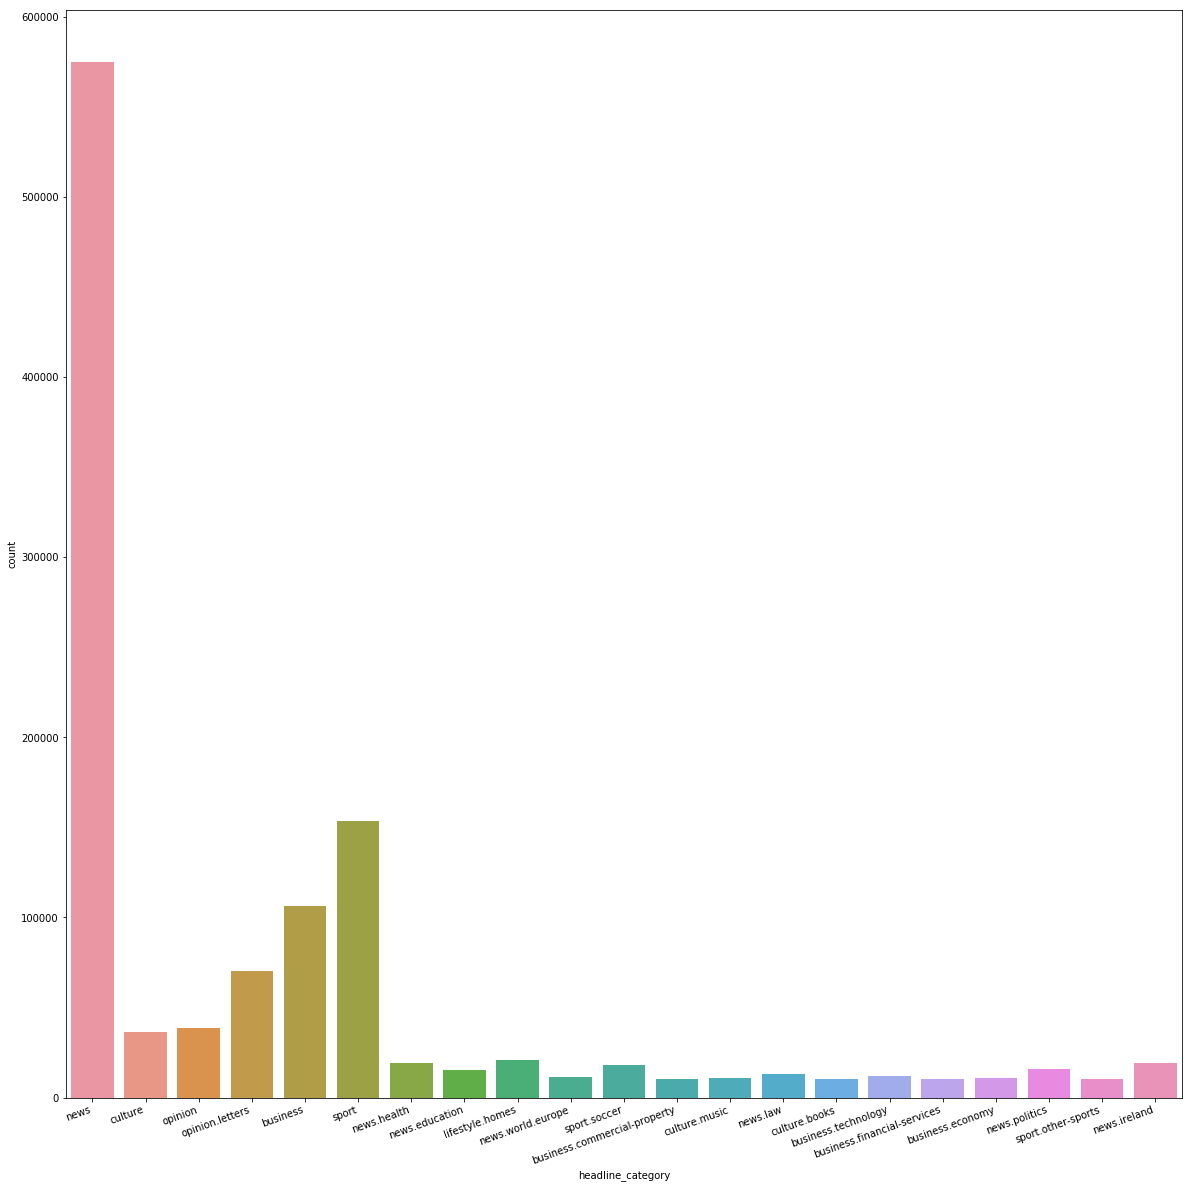

In [8]:
plt.figure(figsize=(20,20))
f = sns.countplot(filtered_df['headline_category'])
f.set_xticklabels(f.get_xticklabels(), rotation=20, ha="right");

# Unbalanced Data

Looks like there are a lot of overlapping categories. 5 business categories, lots of news categories and 3 sports categories. You can combine them and implement the model and compare the results (you will probably get a higher accuracy since similar classes are merged into one, which are the ones our model will often get wrong), but here I have kept them separate.

That issue aside, we have a big problem here that is clearly shown by the count plot. There are way too many headlines classified as news (and to some extent, sports and business), compared to the others. 

**Why is this a problem?**

Well, suppose we want to predict the class without knowing any data -- the chance is 1/21 i.e. 4.76%. Pretty low. Your model can predict a random class and it'll only get 4.76% accuracy.

Now, suppose we feed this data to our model with a validation test that is also so skewed. Most of the models will start to predict news or sports or business on every headline. 
Why is that? For that, let's see how much % of our headlines is 'news'. According to the csv, we have 1.43 million rows. And from the above value_counts, we have found that news corresponds to 574774 of headlines. 

574774/1430000 = 40.19%
So even if the model were to predict that every single headline belongs to the 'news' category, it would have 40.19% accuracy. Now, if it learns the difference between only the major 3 categories -- 'news', 'sports' and 'business', it can reach about 60% accuracy.

What this means is that our model potentially won't learn anything about other classes and if that happens, it will not be able to classify the less frequent categories. 

There are many ways of fixing a class imbalance problem - 
* Using metrics like AUC (Area Under the Curve) instead of accuracy for weights updation.
* Downsampling the classes that have a lot of samples (also called majority classes)
* Upsampling the classes that have very less samples (also called minority classes)
* Using an algorithm that is robust to class imbalance (such as decision trees)
* Generate synthetic samples 
* Penalize the model if the performance on minority classes is low.

Here, we will downsample all the categories to 10000. 

In [9]:
def sampling_k_elements(group, k=10000):
    return group.sample(k)

#Apply the function to all groups
balanced_df = filtered_df.groupby('headline_category').apply(sampling_k_elements).reset_index(drop=True)
balanced_df['headline_category'].value_counts()

lifestyle.homes                 10000
news.health                     10000
culture.music                   10000
sport.other-sports              10000
news                            10000
business.technology             10000
business.economy                10000
news.ireland                    10000
opinion                         10000
business.financial-services     10000
culture                         10000
sport                           10000
culture.books                   10000
news.education                  10000
business                        10000
sport.soccer                    10000
news.law                        10000
opinion.letters                 10000
news.world.europe               10000
news.politics                   10000
business.commercial-property    10000
Name: headline_category, dtype: int64

We now see that each category is of 10000 counts only, giving us a perfectly balanced dataset.

Let us numericalize the categories (instead of 'news', 'culture', 'health', we convert them to some corresponding numbers such as '9', '5', '2', etc). It can be easily done by converting the column to a category and finding out the category codes.

In [10]:
balanced_df['category'] = balanced_df['headline_category'].astype("category").cat.codes
balanced_df.head()

,headline_category,headline_text,category
0,business,Profits up at AIB's Polish arm,0
1,business,Decentralisation programme greeted warmly,0
2,business,TT increases Silvermines stake,0
3,business,And the winners are....Ireland's top innovator...,0
4,business,McCreevy aims to introduce principle of one-sh...,0


Now, there is a new column with numerical categories.
We can now proceed to split our dataset into two - train and validation. We do this in order to ensure that our model does not overfit the dataset. Comparising train accuracy vs validation loss and accuracy tells us how well the model performs for seen data (train) vs unseen data (validation).

We split 80% of dataset in train and 20% of dataset in valid in this case. We also drop the headline_category column, which is no longer required since we have converted the categories to numbers.

In [11]:
np.random.seed(123)
balanced_df = balanced_df.iloc[np.random.permutation(len(balanced_df))]
cut1 = int(0.8 * len(balanced_df)) + 1
try:
    dropped_balanced_df = balanced_df.drop('headline_category', axis=1)
except:
    pass

df_train, df_valid = dropped_balanced_df[:cut1], dropped_balanced_df[cut1:]

Checking the shapes and heads of the new dataframes. There are total 210000 samples (21 categories * 10000 headlines per category).

In [12]:
print(df_train.shape)
df_train.head()

(168001, 2)


,headline_text,category
35754,AIB agrees to defer closure of pension schemes...,3
102278,Exams - it's the final countdown,10
85458,Designs on spacious living in apartments from ...,8
161607,Una Mullally: Senator's remarks show establish...,16
189105,Newslines: Stam and Giggs fit,18


In [13]:
print(df_valid.shape)
df_valid.head()

(41999, 2)


,headline_text,category
126151,Brexit: North can operate under different rule...,12
76635,U2 bring pomp; bombast and defiance to Belfast,7
73190,Ensemble Avalon,7
179549,Australia and the monarchy,17
53713,Conduct Yourselves,5


In [14]:
df_valid['category'].value_counts()

5     2088
4     2066
1     2039
18    2034
7     2029
16    2018
6     2011
11    2007
8     2002
13    2000
10    1995
12    1991
9     1988
19    1987
3     1986
0     1974
2     1967
20    1967
15    1957
14    1948
17    1945
Name: category, dtype: int64

Now we have a relatively balanced validation dataframe (all categories are close to 2000).

We create a dictionary for future use so we know which number corresponds to which category

In [15]:
category_numbers = dict(enumerate(balanced_df['headline_category'].astype("category").cat.categories))
print (category_numbers)

{0: 'business', 1: 'business.commercial-property', 2: 'business.economy', 3: 'business.financial-services', 4: 'business.technology', 5: 'culture', 6: 'culture.books', 7: 'culture.music', 8: 'lifestyle.homes', 9: 'news', 10: 'news.education', 11: 'news.health', 12: 'news.ireland', 13: 'news.law', 14: 'news.politics', 15: 'news.world.europe', 16: 'opinion', 17: 'opinion.letters', 18: 'sport', 19: 'sport.other-sports', 20: 'sport.soccer'}


# Transfer Learning

Now that our data is ready, we will dive into modelling our classifier. 

From Wikipedia, 
> Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. 

Most of machine learning models are very specific. They are very good at handling one problem, and only that one problem. Transfer learning allows us to use the knowledge that a model has learned in domain A (suppose cars) in training a model for a similar problem in domain B (suppose trucks).

What we essentially do is take a pretrained model that was used for a task T1 in certain domain A, and fine tune it to use it on a similar task T2 in domain B.

fast ai features ULMFiT (Universal Language Model Fine-tuning for Text Classification) which as the name suggests, is a universal language model for text classification. It is a language modeller that has been trained on the Wikitext-103 (103 million tokens_ dataset, which is basically the entire wikipedia scraped. There are also other models like this, such as Google's BERT, Open AI's GPT-2 (Generative Pre-Training). 

Import fast ai's text API

In [16]:
from fastai.text import *

### Tokenization 
Next, we need to create a TextLMDataBunch, which fast ai uses for all of its NLP operations. It tokenizes the data while trying to retain most of the meaning of the sentence(we will discuss this more further down). Tokenization refers to breaking down of text into tokens - for example, "This is a sentence" is separated into 4 tokens and forced into lower case - 'this', 'is', 'a', 'sentence'.

DataBunch is what is fed to the neural network. It has 5 components (for supervised learning) - 

1. Training Dataset
2. Training DataLoader
3. Validation Dataset
4. Validation DataLoader
5. (Optional) Test set, which we are not going to use in this kernel.

Dataset and DataLoader are PyTorch classes, so you can read more about them in their docs if you want to know more in detail.

The combination of all these 5 is bunched in the fast ai DataBunch.

TextDataBunch is just a type of DataBunch, however, it has a big limitation. It only works directly if ALL texts have the same length. So to convert our headlines, which are of uneven lengths, we use TextLMDataBunch that concatenates the text without their target labels so our headlines can be used as a TextDataBunch. This TextLMDataBunch is essentially the data that we can feed into language modeler later.

This might take some time...

In [17]:
data_lm = TextLMDataBunch.from_df(path="", train_df=df_train, valid_df = df_valid, text_cols="headline_text", label_cols="category")

Let's save the databunch, so we can directly use it the next time directly.

In [18]:
data_lm.save('irish.pkl')

Let's check how data_lm looks now.

In [19]:
data_lm.show_batch(5)

idx,text
0,( 5 ) mauled by dog at xxmaj antrim school xxbos xxmaj hammerson poised to announce asset sales this week xxbos xxmaj questions and xxmaj answers xxbos xxmaj reflections on the source of ideas xxbos xxmaj paris police arrest 12 linked to xxmaj charlie xxmaj hebdo shootings xxbos xxmaj liverpool stadium move approved xxbos xxmaj cork students capture images of xxmaj ireland from camera attached to a balloon xxbos xxmaj
1,in xxmaj galway xxunk body case xxbos xxmaj anna xxmaj xxunk ; piano xxbos xxmaj the xxmaj homecoming xxbos xxmaj retro gaming comeback continues with xxmaj super xxmaj nintendo xxmaj classic xxbos xxmaj national xxmaj anti - xxmaj poverty xxmaj strategy xxbos xxmaj europe proposes € 7 billion xxmaj greek loan for immediate future xxbos xxmaj researcher stabs colleague in xxmaj antarctic station xxbos xxmaj nama chair xxmaj daly demands
2,be key factor for investors xxbos xxmaj outside the box xxbos i 'm putting my money on a new political movement xxbos xxmaj buffett 's trolley full of woes at xxmaj tesco xxbos xxmaj drowning xxmaj tragedy xxbos xxmaj ryan leads team for xxmaj slovenia xxbos xxmaj name : xxmaj joe xxmaj la xxmaj xxunk xxbos xxmaj five arrested over series of burglaries in xxmaj west xxbos xxmaj when xxmaj
3,record deal with xxmaj sony xxbos xxmaj government interference xxbos xxmaj chinese cub claim xxmaj lampard talks xxbos xxmaj amnesty founder xxmaj xxunk dies ; aged 83 xxbos xxmaj communicating better with our children xxbos xxmaj response to xxmaj magdalene laundries report xxbos xxmaj experimental xxmaj arsenal side make light work of xxmaj bate xxmaj borisov xxbos xxmaj cantillon : xxmaj files reveal xxmaj fed 's 2010 fears over xxup
4,xxmaj summer statement to herald spending increases ahead of budget xxbos xxmaj coke reports large jump in xxup q1 profit xxbos xxmaj law xxmaj matters correction xxbos xxmaj parry hits out at xxmaj uefa xxbos xxmaj the xxmaj beast bombed so i 'm backing xxmaj alt - j for the xxmaj mercury xxbos xxmaj barclays fined £ xxunk million by xxup uk regulators xxbos xxmaj jackie xxmaj skelly xxmaj fitness


### What does Language Modelling mean and what are all those xx terms?

Language modelling, in simple terms, is to understand a language using various techniques, such as its word representations(individual words) or its semantic meaning(whole text/sentence/paragraph).

We use the xx tokens so that the model can understand better and differentiate between two similar texts. For example, "I need a hotdog now" vs "I NEED a hotdog now". The second one implies more urgency, more hunger than the first. However, to have less features and reduce complexity, since all text is converted to lower case, both of them end up as "i need a hotdog now", in which we have definitely lost some understanding after tokenization. "China" is a country, "china" is porcelain. So you can see, proper tokenization is a very important prequisite for language modelling.

Using xx tokens we retain a lot of the original meaning despite converting everything to lowercase.
Here are all of the xx tokens and what they mean - 

1. xxbos = Beggining Of Sentence = This xx token represents the beggining of a sentence.

2. xxpad = Padding = Used for padding if needed to regroup several texts of different lengths into one batch.

3. xxmaj = Denotes that the following word begins with uppercase. So "Hello World" becomes "xxbos xxmaj hello xxmaj world"

4. xxfld = Separates different fields of text (when we have more than one column in dataframe for text classification, for eg, if we had both headlines and article text in two seperate columns, we would have 2 fields).

5. xxup = Denotes that the following word is entirely uppercase. "... NEED... " becomes "...xxup need..."

6. xxrep = Repetitions = Denotes how many times a CHARACTER has been repeated consecutively, if it has been repeated consecutively. "...oooo ..." becomes "...xxrep 4 o ..."

7. xxwrep = Same thing as xxrep but for words. "...muda muda muda muda muda..." becomes "...xxwrep 5 muda..."

8. xxunk = Denotes an unknown word, that is not in our vocabulary. 

Let's check the top 40 words used in the headlines, since we are done with the tokenization.

The default size of the vocabulary is 60000. A word has to occur at least 2 times to be added to the vocabulary.

In [20]:
data_lm.vocab.itos[:40]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'to',
 'in',
 'of',
 "'",
 'the',
 'for',
 ':',
 '-',
 "'s",
 'on',
 'a',
 'and',
 ';',
 '€',
 'at',
 'with',
 'irish',
 'as',
 'by',
 'over',
 'm',
 'new',
 'is',
 'ireland',
 'from',
 '?',
 'be',
 'up',
 'says',
 'dublin',
 'after']

Mostly the tokens, and the common words.

The nouns are Ireland, Irish and Dublin. There's also a €.
Until recently many believed that removing stopwords was an essential step before modelling, but views have changed. In this case, I am not going to remove them, because stop words have been shown to contribute a lot to the meaning of a sentence.

For those who are familiar with stopwords, they are words that always occur in texts, regardless of their nature. For eg, "an", "a", "in", "the", etc. compared to (say), a word like "vindicate" that is probably mostly present in only legal matters.

Now we define our language model learner, in which we pass our DataBunch and specify the pretrained network that we want to use - AWD_LSTM that was used on WT-103 (Wikitext-103). 

drop_mult is a hyper-parameter that defines by how much we want to multiply the dropout layers of our network. Dropout refers to dropping out units in the network(both hidden and visible) to avoid overfitting the network. 

drop_mult = 0.3 means all dropout layers's probability will be multiplied by 0.3. drop_mult = 1.5 means all dropout layers's probability will be multiplied by 1.5. AWD_LSTM has a dropout in every layer, so this parameter is quite important.

To understand it simply, if model is overfitting, increase drop_mult.
If model is underfitting, decrease drop_mult.

In [21]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

In [22]:
learner.save_encoder('irish_encoder')

We save the encoded learner, so we can use it in our classifier. This encoder is what understands the text.

Now that we have tried our language modeller and made an encoder that can understand text, we need to create a text classifier that separates the 21 classes we had. For that, first, we need to create a TextClasDataBunch, which is another type of DataBunch.

In this we specify vocab = data_lm.train_ds.vocab to ensure that the vocabularly that  we had in language modelling is the same as what we will have for the text classifier.

In [23]:
data_clas = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df = df_valid, vocab=data_lm.train_ds.vocab, text_cols="headline_text",label_cols="category")

Here we create the text classifier, using the pretrained AWD_LSTM model that was used for WT-103.

In [24]:
clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.1)

Load the encoder that was obtained from language model learner...
You can check out the details of the entire network if you wish. 

In [25]:
clas.load_encoder('irish_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (168001 items)
x: TextList
xxbos xxup aib agrees to defer closure of pension schemes pending more talks at xxmaj labour xxmaj court,xxbos xxmaj exams - it 's the final countdown,xxbos xxmaj designs on spacious living in apartments from £ 175;000,xxbos xxmaj una xxmaj mullally : xxmaj senator 's remarks show establishment does not want young people in politics,xxbos xxmaj newslines : xxmaj stam and xxmaj giggs fit
y: CategoryList
3,10,8,16,18
Path: .;

Valid: LabelList (41999 items)
x: TextList
xxbos xxmaj brexit : xxmaj north can operate under different rules to xxup uk – xxmaj coveney,xxbos xxup u2 bring pomp ; xxunk and defiance to xxmaj belfast,xxbos xxmaj ensemble xxmaj avalon,xxbos xxmaj australia and the monarchy,xxbos xxmaj conduct xxmaj yourselves
y: CategoryList
12,7,7,17,5
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(30784, 400, padding_idx=1)
      

Fast ai provides an easy way to finding the ideal learning rate for the mode that works most of the time.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


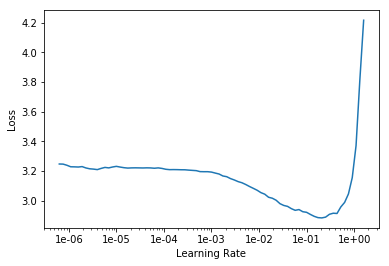

In [26]:
clas.lr_find()
clas.recorder.plot()

The y axis is the loss, and the x axis is the learning rate. If you're thinking that we should pick the learning rate that corresponds to the lowest loss, then you are mistaken in your thinking. We want our model to learn as fast as possible but if the loss is minimum, then what our model will learn is also minimum.

Most of the losses vs learning rate graphs look quite similar - They go down slowly to a certain point, stay for a few values, and then shoot up very rapidly because of overfitting. 

A good thumb of rule is to pick the loss as LR(Loss_min)/10, where LR(Loss_min) refers to the learning rate where the loss is minimum, but this does not always work. In cases like these, you might have to experiment a bit.

We specify the number of epochs(5 here), and the maximum learning rate to the classifier and train.

In [27]:
clas.fit_one_cycle(5, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,2.033956,1.866975,0.436153,00:41
1,1.968535,1.815296,0.449130,00:39
2,1.918141,1.775499,0.458582,00:41
3,1.860909,1.713121,0.479369,00:41
4,1.849816,1.710343,0.480797,00:40


### One cycle fit 

fastai uses 1 cycle fit, which works very well. You can check out the original paper  by Leslie Smith [here](https://arxiv.org/abs/1803.09820). 

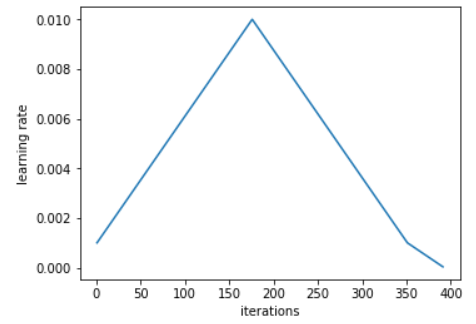
Image from [Sylvain Gugger's post](https://sgugger.github.io/the-1cycle-policy.html) on 1cycle fit, which you can refer to if you want to understand 1cycle in detail.

Essentially, we start slow (low learning rate), then keep raising the learning rate until it hits maximum, and then slow down again. When all of this is done once, one cycle is complete.

# Fine-tuning

After 5 epochs on a pretrained model, we have already got nearly half chance of predicting the correct class amongst 21 (almost 10 times better than picking the correct class at random). In less than 5 minutes, too.

But we can surely improve the accuracy further. Let us keep all the layers of the pretrained model frozen(as it is) and train again.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


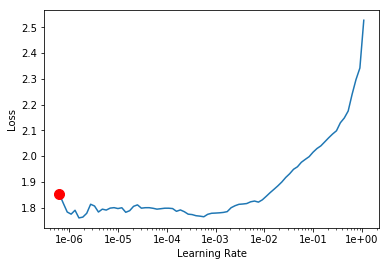

In [28]:
clas.freeze_to(-2)
clas.lr_find()
clas.recorder.plot(suggestion=True)

Here we use another parameter, moms, which is another parameter that Leslie Smith advices to use. It stands for momentum. Since I'm picking an aggressive learning rate here, the momentum will help slow down the overshoot if there is any. 

Intuitively, we want to have

1) a higher momentum with a low learning rate

2) a low momentum with a high learning rate

> To accompany the movement toward larger learning rates, Leslie found in his experiments that decreasing the momentum led to better results. This supports the intuition that in that part of the training, we want the SGD to quickly go in new directions to find a flatter area, so the new gradients need to be given more weight. In practice, he recommends to pick two values likes 0.85 and 0.95, and decrease from the higher one to the lower one when we increase the learning rate, then go back to the higher momentum as the learning rate goes down.

Cited from [Sylvain Gugger's post](https://sgugger.github.io/the-1cycle-policy.html) 

In [29]:
clas.fit_one_cycle(5, 5e-04, moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,1.801657,1.647998,0.497679,00:47
1,1.633636,1.547174,0.524489,00:47
2,1.519548,1.489590,0.540608,00:48
3,1.383606,1.461653,0.550108,00:46
4,1.313996,1.454877,0.553489,00:45


Save the encoder for the classifier so we don't have to train next time. We can simply load clas.load_encoder('freeze_2_encoder').

You can see that the training loss actually went up the last iteration, so we will need to unfreeze more layers to get better results.

In [30]:
clas.save_encoder('freeze_2_encoder')

We'll keep the model frozen except the last three layers and train again.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-05


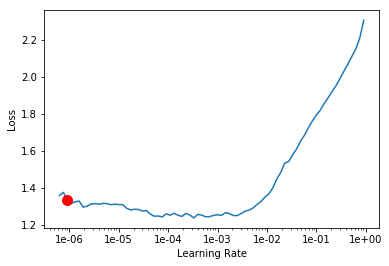

In [31]:
clas.freeze_to(-3)
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [32]:
clas.fit_one_cycle(5, 3.2e-05, moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,1.291520,1.440766,0.557251,01:06
1,1.253526,1.419420,0.564228,01:04
2,1.239986,1.407793,0.568966,01:04
3,1.187790,1.408080,0.568347,01:04
4,1.219087,1.409887,0.568037,01:07


In [33]:
clas.save_encoder('freeze_3_encoder')

Finally, we will unfreeze the entire model and train.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.31E-08


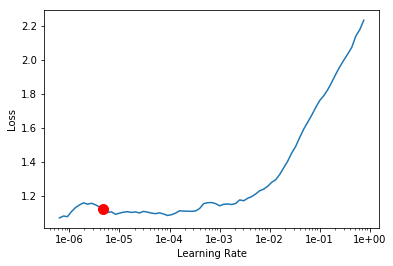

In [34]:
clas.unfreeze()
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [35]:
clas.fit_one_cycle(3, 5e-05, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,accuracy,time
0,1.152126,1.367695,0.579538,01:27
1,1.052634,1.331585,0.594324,01:26
2,0.954456,1.332402,0.593990,01:29


In [36]:
clas.save_encoder('final_encoder')

And we're done. Near to 60% accuracy is pretty good for training for less than 20 minutes of training on a 21 classes problem with quite a few similar classes. This is the power of transfer learning. I'm sure the accuracy can be improved by merging similar classes, taking more gradual approach and having more epochs or simply getting more data of each class, but I'm quite satisfied with this. 

Let's predict some stuff!

In [37]:
clas.predict("Artist A's latest album is soaring through the charts")

(Category 7,
 tensor(7),
 tensor([7.2135e-03, 4.4145e-03, 2.1481e-03, 5.8112e-04, 2.3268e-03, 2.8505e-02,
         2.9799e-05, 9.2846e-01, 5.9755e-03, 1.1126e-02, 1.6109e-03, 1.1466e-03,
         1.4541e-03, 3.8511e-05, 9.5497e-05, 1.2366e-03, 7.6314e-04, 3.2853e-04,
         1.9413e-03, 4.5058e-04, 1.5147e-04]))

There are two tensors here - The first tensor (7) tells us which class it probably belongs to, and the long, second tensor is a list of probabilities.

But well, what category did 7 belong to, again?
Remember the dictionary that we made when we numericalized the categories? We can use that to find out.

In [38]:
print(category_numbers.get(7))

culture.music


We can check that the sum of all of the probabilities is 1.

In [39]:
clas.predict("Beatles' latest album is soaring through the charts")[2].sum()

tensor(1.)

Some more testing and fun...

In [40]:
clas.predict("An underdog wins the worldcup 2-0")

(Category 18,
 tensor(18),
 tensor([1.5698e-02, 3.4194e-04, 2.6432e-04, 2.8494e-03, 5.9654e-03, 1.1416e-02,
         4.7690e-03, 4.2624e-04, 2.2889e-03, 2.0392e-02, 1.6181e-02, 1.7965e-03,
         6.5203e-04, 4.4590e-04, 2.2879e-04, 9.5777e-05, 1.3446e-02, 4.2653e-04,
         6.8379e-01, 2.1546e-01, 3.0612e-03]))

In [41]:
category_numbers.get(18) #To know what category 18 belongs to, let us see...

'sport'

Pretty inconvenient to predict and find out manually each time. Let's make a function to predict and try predicting something not related to Ireland. I'll take the NIFTY stock, which is not related to Ireland.

In [42]:
def pred_classes(text):
    print(category_numbers.get(int(clas.predict(text)[1])))    

In [43]:
pred_classes("NIFTY falls down by 100 rupees")

business


In [44]:
pred_classes("Eggs and cholestrol - is eating many eggs really unhealthy for your heart?")

news.health


In [45]:
pred_classes("We need to do something now, or else our planet is doomed")

opinion


In [46]:
pred_classes("10 ways to improve your kitchen")

lifestyle.homes


In [47]:
pred_classes("A couple gets 10 years for killing a teddy bear")

news


> "Transfer learning will be the next drive of ML success" - Andrew Ng

References - 
1. [fastai text docs](https://docs.fast.ai/text.html)
2. [Towards Data Science - Machine Learning — Text Classification, Language Modelling using fast.ai by Javaid Nabi](https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d)
3. [Towards Data Science -Transfer Learning in NLP for Tweet Stance Classification by Prashanth Rao](https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde)
4. [Sylvain Gugger's excellent post on one cycle fit](https://sgugger.github.io/the-1cycle-policy.html)



